EEG 2 ACTIVITIES CLASSIFIER

## citacije csp-ja, autoreg pato

In [85]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import scipy.signal as sig
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import pandas as pd
import os
from mne.decoding import CSP
from scipy.signal import welch


from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score


In [2]:
#filtering with band-pass fir filter
def filter_with_bandpass(S,fs,low_cutoff = 8,high_cutoff = 13,order = 501, plot_filter=False):
    S_filtered = np.copy(S)

    b = sig.firwin(order, [low_cutoff, high_cutoff], fs=fs, pass_zero = False)
    
    for i in range(len(S_filtered)):
        
        S_filtered[i] = sig.lfilter(b,[1],S_filtered[i])


    if plot_filter:
        w,h = sig.freqz(b)
        plt.plot(w * fs / (2 * np.pi), abs(h), 'b')
        plt.title('Band-Pass Filter Frequency Response (8.0 Hz to 13.0 Hz)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.show()
    
    return S_filtered

In [3]:
#READING THE SIGNALS
def read_edf(rec_num):
    all_data = []
    for num in [3,7,11]:
        rec_name = f"files/S{rec_num:03d}/S{rec_num:03d}R{num:02d}.edf"
        #read edf file 
        edf_file = pyedflib.EdfReader(rec_name)

        #num of signals
        n_signals = edf_file.signals_in_file

        #labels of which signals it is (on the head)
        signal_labels = edf_file.getSignalLabels()
        signal_labels = [label.replace(".", "") for label in signal_labels]

        #sampling freq
        sample_frequency = edf_file.getSampleFrequencies()
        sample_frequency = sample_frequency[0]

        #get annotations on the signal (T0, T1,T2)
        annotations = edf_file.readAnnotations()
        start_event_times = annotations[0]
        
        durations = annotations[1]

        #T0 is the base state, T1 is the imagining of clinching left fist, T2 is the imagining of clinching of right fist
        descriptions = annotations[2]
        
        #all 64 signals
        signals = np.zeros((n_signals, len(edf_file.readSignal(0))))
        for i in range(n_signals):
            signal = edf_file.readSignal(i)
            signals[i] = signal

        signals = filter_with_bandpass(signals, sample_frequency)
        all_data.append([signals,signal_labels,start_event_times, durations, descriptions, sample_frequency])
        edf_file.close()

    return all_data

In [4]:
def read_edf_database():
    all_signals = []
    for i in range(109):
        all_signals.append(read_edf(i))
    return all_signals

In [96]:
def plot_signal_with_annotations_and_state_changes(signals,signal_labels, start_event_times, durations, descriptions, fs, 
                                                   signal_idx="C1", start_time=0, end_time=None,S=False, S_signal_select = 0):
    
    
    if not S:
        signal_idx_index = signal_labels.index(signal_idx)

        # Select the signal to plot
        signal = signals[signal_idx_index]
    else:
        signal = signals[S_signal_select]
        signal_idx  = "S"  + str(S_signal_select + 1)

    # Determine the sample range for the specified time window
    if end_time is None:
        end_time = len(signal) / fs  # Default to the entire signal duration
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)

    # Extract the portion of the signal to display
    signal_segment = signal[start_sample:end_sample]
    time_segment = np.linspace(start_time, end_time, len(signal_segment))

    # Filter annotations to match the time window
    filtered_events = [
        (start, dur, desc) for start, dur, desc in zip(start_event_times, durations, descriptions)
        if start >= start_time and start < end_time
    ]

    # Plot the signal
    plt.figure(figsize=(15, 6))
    plt.plot(time_segment, signal_segment, label=f"Signal {signal_idx}", color="blue", linewidth=1)
    plt.title(f"Signal {signal_idx} with Annotations (Time {start_time}s to {end_time}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot colored annotation bars and vertical lines for state changes
    color_map = {"T0": "green", "T1": "red", "T2": "orange"}  # Map descriptions to colors
    y_bar_pos = max(signal_segment) + 10  # Position for annotation bars
    prev_description = None  # Keep track of the previous state
    for start, duration, description in filtered_events:
        # Plot annotation bar
        color = color_map.get(description, "black")  # Default to black if description not in color_map
        plt.hlines(y_bar_pos, start, start + duration, colors=color, linewidth=8, label=description if start == filtered_events[0][0] else "")
        plt.text(
            start + duration / 2, y_bar_pos + 5, description, color=color, fontsize=8, ha="center", va="bottom"
        )

        # Plot vertical line for state change
        if description != prev_description:  # State change detected
            plt.axvline(x=start, color="black", linestyle="--", linewidth=1, alpha=0.7, label="State Change" if prev_description is None else "")
        prev_description = description

    # Avoid duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Adjust axis limits to accommodate annotations
    
    plt.ylim([min(signal_segment) - 10, y_bar_pos + 10])

    # Show the plot
    plt.show()

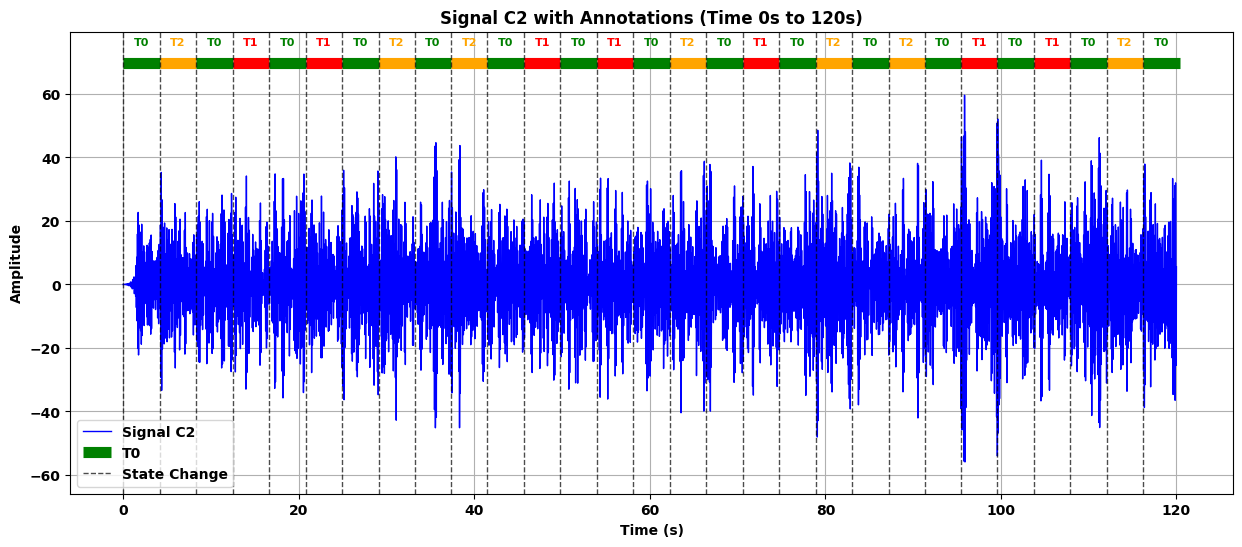

In [97]:
#RO4 files are the files where imagining clinching left and right fist
signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf(1)[0]
plot_signal_with_annotations_and_state_changes(signals,signal_labels, start_event_times, durations, descriptions, fs, "C2", 0,120)

In [7]:
def get_avg_covariance_matrices(matrix, start_event_times, durations, descriptions, fs):
    #get samples instead of seconds
    start_event_samples = [int(start*fs) for start in start_event_times]
    duration_samples = [int(duration * fs) for duration in durations]

    #avg covariance matrices
    avg_cov_T1 = np.zeros((64,64))
    num_of_T1 = 0
    avg_cov_T2 = np.zeros((64,64))
    num_of_T2 = 0

    #through all states
    for i in range(len(start_event_samples)):
        #matrix of the current state
        tmp_mtx = np.matrix((64, duration_samples[i]))
        tmp_mtx = matrix[:,start_event_samples[i]:start_event_samples[i] + duration_samples[i]]

        #cases for each state, calculate covariace and add to the avg covaricance matrix
        if descriptions[i] == "T1":
            prod = tmp_mtx @ tmp_mtx.T
            #avg_cov_T1 += prod / len(tmp_mtx[0])
            avg_cov_T1 += prod #/ np.linalg.trace(prod)
            num_of_T1 += 1

        elif descriptions[i] == "T2":
            prod = tmp_mtx @tmp_mtx.T
            #avg_cov_T2 += prod / len(tmp_mtx[0])
            avg_cov_T2 +=prod #/ np.linalg.trace(prod)
            num_of_T2 += 1
    
    avg_cov_T1 = avg_cov_T1 / num_of_T1
    avg_cov_T2 = avg_cov_T2 / num_of_T2

    return avg_cov_T1, avg_cov_T2



In [8]:
def get_avg_covariance_matrices_first_few(matrix, start_event_times, durations, descriptions, fs, num=2):

        #get samples instead of seconds
        start_event_samples = [int(start*fs) for start in start_event_times]
        duration_samples = [int(duration * fs) for duration in durations]

        #counters for states
        counter_1 = 0
        counter_2 = 0

        for i,description in enumerate(descriptions):

                if description == "T1":
                        counter_1 += 1
                elif description == "T2":
                        counter_2 += 1
                if counter_1 >= num and counter_2 >= num:
                        break

        #duration of the matrix used to calculate W
        duration_whole_samples = start_event_samples[i] + duration_samples[i]

        #
        tmp_mtx = np.zeros((64, duration_whole_samples))
        tmp_mtx = matrix[:,:duration_whole_samples]

        cov_T1, cov_T2 = get_avg_covariance_matrices(tmp_mtx, start_event_times[:i+1], durations[:i+1], descriptions[:i+1], fs)

    
        return cov_T1, cov_T2, duration_whole_samples, i

        
        

In [9]:
def get_top_eigenvectors_build_W(avg_cov_T1, avg_cov_T2, n):
    mtx = np.linalg.inv(avg_cov_T2) @ avg_cov_T1
    
    eigenvalues, eigenvectors = np.linalg.eig(mtx)
    
    eigenvalues = [np.abs(eigenvalue) for eigenvalue in eigenvalues]
    sorted_eigenvalues = sorted(eigenvalues)


    indices_max= [np.where(eigenvalues == value) for value in sorted_eigenvalues[-n:]]
    indices_max = indices_max[::-1]

    indices_min = [np.where(eigenvalues == value) for value in sorted_eigenvalues[:n]]
    indices_min = indices_min[::-1]
    

    indices = indices_max + indices_min


    W =[ np.real(eigenvectors[:,i].flatten()) for i in indices]

    for i,el in enumerate(W):
        if len(el) > 100:
            W[i] = W[i][:64]

    return np.array(W)

In [10]:
def csp_filtering(signals, start_event_times, durations, descriptions, fs , n, num=1):
    #TODO: change so that you take first few intervals to "teach" csp and then use the matrix on the others
    avg_cov_T1, avg_cov_T2, duration_whole_samples, ind = get_avg_covariance_matrices_first_few(signals, start_event_times, durations, descriptions, fs, num=num)
    #avg_cov_T1, avg_cov_T2 = get_avg_covariance_matrices(signals, start_event_times, durations, descriptions, fs)
    #generalized eigenvalues, eigenvectors
    W = get_top_eigenvectors_build_W(avg_cov_T1, avg_cov_T2, n)

    S = W @ signals

    #S = W @ signals

    return S, W, ind

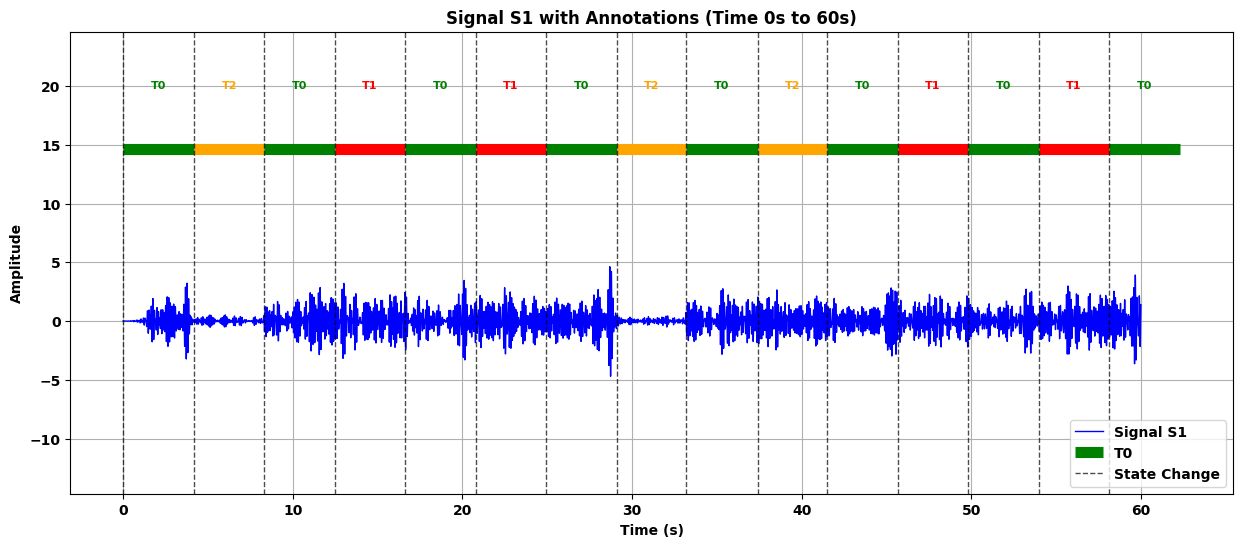

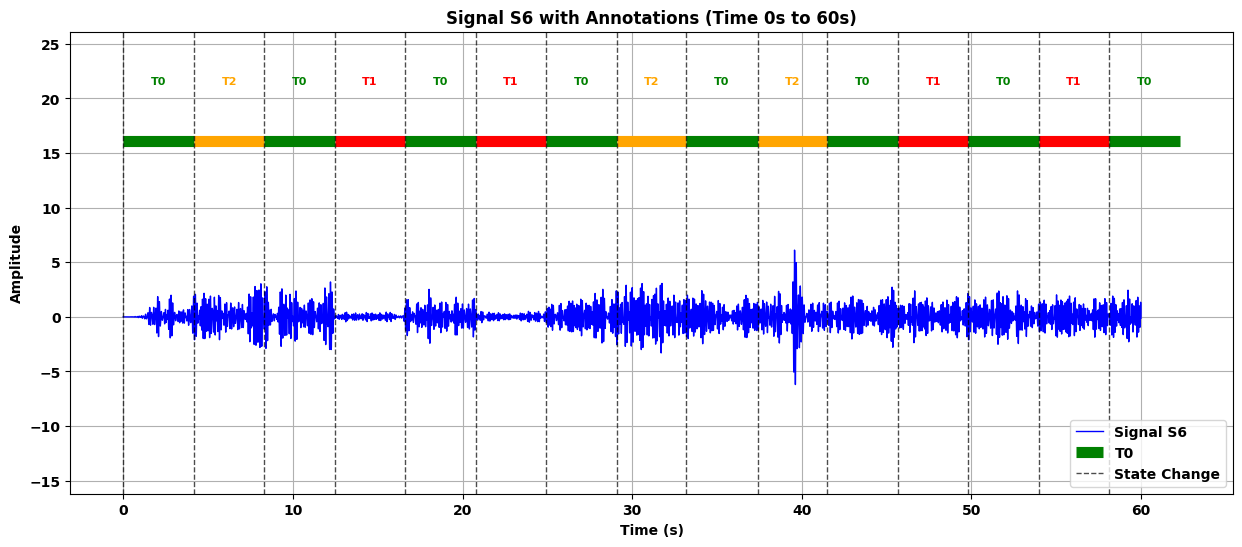

In [100]:
S,W, ind = csp_filtering(signals, start_event_times, durations,descriptions, fs, 3, num=2)

plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=0, start_time=0, end_time=60)
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=5, start_time=0, end_time=60)



In [12]:
#S = filter_with_bandpass(S, fs)
#plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=0, start_time=0, end_time=60)
#plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=4, start_time=0, end_time=60)

In [79]:


def get_features(S, start_event_times, durations, descriptions,fs, p = 10):

    #get samples instead of seconds
    start_event_samples = [int(start*fs) for start in start_event_times]
    duration_samples = [int(duration * fs) for duration in durations]

    features = []

    #through all states
    for i in range(len(start_event_samples)):
        tmp = []
        
        #cases for each state, calculate covariace and add to the avg covaricance matrix
        if descriptions[i] == "T1":

            for signal in S:
                tmp.append(np.log(np.var(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])))


                # Compute FFT
                fft_values = np.fft.fft(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])
    
                frequencies = np.fft.fftfreq(len(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]]), 1/fs)

                # Compute power spectrum (magnitude squared of FFT)
                power_spectrum = np.abs(fft_values) ** 2

                peak_amplitude = np.max(power_spectrum)
    
                tmp.append(peak_amplitude)
                cumulative_power = np.cumsum(power_spectrum)
                total_power = cumulative_power[-1]
                median_frequency = frequencies[np.searchsorted(cumulative_power, total_power / 2)]
                tmp.append(median_frequency)
                highest_power_freqency = frequencies[np.argmax(power_spectrum)]
                tmp.append(highest_power_freqency)

                model = AutoReg(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]], p)
                model_fitted = model.fit()
                #AR parameters (coefficients)
                ar_params = model_fitted.params 

                #tmp.extend(ar_params)
                
            tmp.append("T1")
           
            features.append(tmp)
            

        elif descriptions[i] == "T2":
            
            for signal in S:
                tmp.append(np.log(np.var(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])))

                fft_values = np.fft.fft(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])
                frequencies = np.fft.fftfreq(len(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]]), 1/fs)

                power_spectrum = np.abs(fft_values) ** 2
                peak_amplitude = np.max(power_spectrum)
                tmp.append(peak_amplitude)
                cumulative_power = np.cumsum(power_spectrum)
                total_power = cumulative_power[-1]
                median_frequency = frequencies[np.searchsorted(cumulative_power, total_power / 2)]
                tmp.append(median_frequency)
                highest_power_freqency = frequencies[np.argmax(power_spectrum)]
                tmp.append(highest_power_freqency)

                model = AutoReg(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]], p)
                model_fitted = model.fit()
                #AR parameters (coefficients)
                ar_params = model_fitted.params
                #tmp.extend(ar_params)

            tmp.append("T2")
            features.append(tmp)
        

    return features

In [83]:
#read for one person
all_signals = read_edf(1)

for i,signal in enumerate(all_signals):
    if i == 0:
        S, W, ind = csp_filtering(signal[0],signal[2], signal[3],signal[4],signal[5], 3, num=1)
    else:
        S = W @ signal[0]
        
    #S= csp_filtering(signal[0],signal[2], signal[3],signal[4],signal[5], 6)

    S_filtered = filter_with_bandpass(S, signal[5])
    #S_filtered = S
    #plot_signal_with_annotations_and_state_changes(S_filtered, signal[1],signal[2], signal[3],signal[4],signal[5], start_time=0, end_time=30, S=True, S_signal_select=0)

    features = get_features(S_filtered, signal[2], signal[3], signal[4], signal[5],p =10)


    if i == 0: 
        df = pd.DataFrame(features)
    
    else:
        df_new =  pd.DataFrame(features)

        df = pd.concat([df,df_new], ignore_index=True)
  

In [104]:
sensitivities = {
        "LDA" : [],
        #"QDA" : [],
        "Random Forest": [],
        "XGBOOST" :[],
        "Logistic regression": [],
        "Decision trees": [],
        #"Support vector machines":  [],
        "Naive Bayes":  [],
        #"MLP": []
    }

specificities = {
        "LDA" : [],
        #"QDA" : [],
        "Random Forest": [],
        "XGBOOST" :[],
        "Logistic regression": [],
        "Decision trees": [],
        #"Support vector machines":  [],
        "Naive Bayes":  [],
        #"MLP": []
    }

models = {
        "LDA" : LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
        #"QDA" : QuadraticDiscriminantAnalysis(),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBOOST" : XGBClassifier(eval_metric='logloss'),
        "Logistic regression": LogisticRegression(),
        "Decision trees": DecisionTreeClassifier(),
        #"Support vector machines": SVC(),
        "Naive Bayes": GaussianNB(),
        #"MLP": MLPClassifier(max_iter=500)
        
    }

results_lengths = []

for j in range(1,110):    
    #read for one person
    all_signals = read_edf(j)

    for i,signal in enumerate(all_signals):
        if i == 0:
            S, W, ind = csp_filtering(signal[0],signal[2], signal[3],signal[4],signal[5], 3, num=1)
        else:
            S = W @ signal[0]
        
            #S, W, ind = csp_filtering(signal[0],signal[2], signal[3],signal[4],signal[5], 3, num=10)
        
        S_filtered = S

        #S_filtered = filter_with_bandpass(S, signal[5])
       

        features = get_features(S_filtered, signal[2], signal[3], signal[4], signal[5],p =10)


        if i == 0:
            df = pd.DataFrame(features)
        
        else:
            df_new =  pd.DataFrame(features)

            df = pd.concat([df,df_new], ignore_index=True)

        
    X = df.drop(len(df.columns)-1, axis=1)
    y = df[len(df.columns)-1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    #shuffle false because its time series
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, shuffle=False)

    scaler  = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)


    print(f"for {j}")

    for key,value in models.items():
        clf = value
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Sensitivity 
        sensitivity = tp / (tp + fn)
        sensitivities[key].append(sensitivity)

        # Specificity
        specificity = tn / (tn + fp)
        specificities[key].append(specificity)
        
        #print(f"For {key} the Sensitivity is: {sensitivity:.2f}")
        #print(f"For {key} the Specificity is: {specificity:.2f}")
    

    results_lengths.append(len(df))

for key in sensitivities.keys():
    print(f"avg sensitivity for {key} is {np.mean(sensitivities[key])} +- {np.std(sensitivities[key])}")
    print(f"avg specificity for {key} is {np.mean(specificities[key])} +- {np.std(specificities[key])}") 

    

SyntaxError: unterminated string literal (detected at line 108) (1963873341.py, line 108)